# download packages

In [1]:
%%capture
!pip install pytorch-lightning
!pip install torchmetrics
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install -U opencv-python-headless==4.1.2.30

# download data

In [2]:
!git clone https://github.com/bioinfolabic/UTFPR-SBD3.git

Cloning into 'UTFPR-SBD3'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 60 (delta 0), reused 3 (delta 0), pack-reused 56
Unpacking objects: 100% (60/60), done.


In [3]:
cd UTFPR-SBD3/

/content/UTFPR-SBD3


In [4]:
!ls

classes.txt	    extract_dataset.py	   Statistics.png    utfpr_sbd3.partb
cv_split_data.json  read_cv_split_data.py  Table1.png	     utfpr_sbd3.partc
example_dataset.py  README.md		   utfpr_sbd3.parta  utfpr_sbd3.partd


# prepare data

In [5]:
!python extract_dataset.py 

Finished!


In [6]:
from glob import glob
annotations=sorted(glob('annotations/*'))
masks=sorted(glob('masks/*'))
images=sorted(glob('images/*'))
len(images),len(masks),len(annotations)

(4500, 4500, 4500)

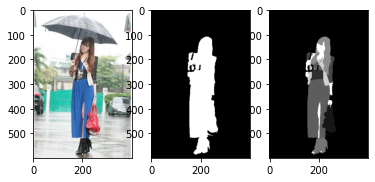

In [7]:
from PIL import Image
import cv2
from matplotlib import pyplot as plt 
import numpy as np
idx=25
mask1=Image.open(masks[idx])
annot1=Image.open(annotations[idx])
img1=Image.open(images[idx])
fig,ax=plt.subplots(ncols=3)
ax[0].imshow(img1)
ax[1].imshow(mask1)
ax[2].imshow(annot1,cmap='gray')

In [8]:
img1.size

(400, 600)

In [9]:
np.array(annot1).max(),np.array(annot1).min()

(11, 0)

In [10]:
data_dicts=[{
    "image":image_name,'label':label_name}
    for image_name,label_name in zip(images,annotations)
    ]

In [11]:
from sklearn.model_selection import train_test_split
train_files,val_files=train_test_split(data_dicts,test_size=0.2,random_state=0)

In [12]:
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader,Dataset
import torch

# augmentation

In [13]:
aug=A.Compose(
    [
     A.Resize(384,384),
     A.HorizontalFlip(p=0.5),
     A.Rotate(10),
    A.ColorJitter(0.2,0.2,0,0),
        A.GridDistortion (),
     A.Normalize(),
     ToTensorV2(p=1.0)
    ]
)

# data loader

In [14]:
class DataReader(Dataset):
  def __init__(self,data,transform):
    self.data=data
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_path=self.data[index]['image']
    label_path=self.data[index]['label']

    image=np.array(Image.open(image_path))
    label=np.array(Image.open(label_path))

    transformed=self.transform(image=image,mask=label)
    image=transformed['image']
    label=transformed['mask']
    label=np.expand_dims(label,0)
    return image,label

In [15]:
sample_data=DataReader(data=data_dicts,transform=aug)
sample_loader=DataLoader(sample_data,batch_size=1)
sample_batch=next(iter(sample_loader))
sample_batch[0].shape,sample_batch[1].shape

(torch.Size([1, 3, 384, 384]), torch.Size([1, 1, 384, 384]))

In [16]:
sample_batch[1].max(),sample_batch[1].min()

(tensor(11, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

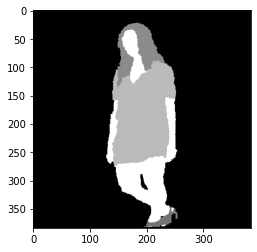

In [17]:
plt.imshow(sample_batch[1].numpy()[0][0],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'batch of images')

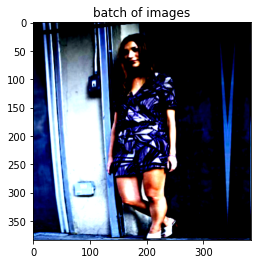

In [18]:
plt.figure()
grid_image=torchvision.utils.make_grid(sample_batch[0],4,1)
plt.imshow(grid_image.permute(1,2,0))
plt.title('batch of images')


In [19]:
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything,LightningModule,Trainer
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from segmentation_models_pytorch.losses import DiceLoss

# training

In [20]:
class SegmentClass(LightningModule):
  def __init__(self):
    super(SegmentClass,self).__init__()
    self.cls=18+1
    #model
    self.model = smp.Unet(
        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=self.cls,                      # model output channels (number of classes in your dataset)
    )
    #loss function
    self.loss=DiceLoss(mode='multiclass',classes=self.cls,from_logits=True)
    #metric
    self.iou=torchmetrics.JaccardIndex(self.cls)
    #batchsize
    self.batchsize=24
    #lr
    self.lr=1e-3
    self.workers=4

  def forward(self,x) :
    return self.model(x)
      
  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(),lr=self.lr,weight_decay=1e-5)
    scheduler=CosineAnnealingWarmRestarts(opt,T_0=10,T_mult=1,eta_min=1e-5,last_epoch=-1)
    return {'optimizer':opt,'lr_scheduler':scheduler}

  def train_dataloader(self):
    data=DataReader(data=train_files,transform=aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=True,num_workers=self.workers)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('train_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('train_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    data=DataReader(data=val_files,transform=aug)
    loader=DataLoader(data,batch_size=self.batchsize,shuffle=False,num_workers=self.workers)
    return loader

  def validation_step(self,batch,batch_idx):
    image,segment=batch[0],torch.squeeze(batch[1],1).long()
    out=self(image)
    loss=self.loss(out,segment)
    iou=self.iou(out,segment)
    self.log('val_loss',loss,on_step=False,on_epoch=True,prog_bar=True)
    self.log('val_iou',iou,on_step=False,on_epoch=True,prog_bar=True)
    return loss

In [21]:
model=SegmentClass()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [22]:
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor=LearningRateMonitor(logging_interval='epoch')

trainer=Trainer(max_epochs=1,
#                 resume_from_checkpoint=ckp,
                gpus=1,precision=16,
                callbacks=[lr_monitor])

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model)
# torch.save(model.state_dict(), '200_epochs.pt')

Missing logger folder: /content/UTFPR-SBD3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | Unet         | 24.4 M
1 | loss  | DiceLoss     | 0     
2 | iou   | JaccardIndex | 0     
---------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.878    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation: 0it [00:00, ?it/s]

In [24]:
# model.load_state_dict(torch.load('../200_epochs.pt'))

In [25]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_iou            0.23861195147037506
        val_loss            0.6397316455841064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_iou': 0.23861195147037506, 'val_loss': 0.6397316455841064}]

# testing some images

In [26]:
testaug=A.Compose(
    [
     A.Resize(384,384),
     A.Normalize(),
     ToTensorV2(p=1.0)
    ]
)

In [27]:
imgs,preds,labels=[],[],[]
model=model.to('cuda')
model=model.eval()
import random
with torch.no_grad():
    with torch.cuda.amp.autocast():
        for i in random.choices(val_files, k=3):
            image_path,label_path=i.items()
            image_raw=np.array(Image.open(image_path[1]))
            label_raw=np.array(Image.open(label_path[1]))

            transformed=testaug(image=image_raw,mask=label_raw)
            image=transformed['image']
            label=transformed['mask']
            label=torch.unsqueeze(label,0)
            image=torch.unsqueeze(image,0)
            pred=model(image.to('cuda'))
            pred=torch.sigmoid(pred)
            pred=pred.detach().cpu().numpy()[0]
            pred=np.argmax(pred,axis=0).astype(np.uint8)
            imgs.append(image_raw)
            preds.append(cv2.resize(pred,label_raw.shape))
            labels.append(label_raw)
            
    

In [28]:
imgs_array=np.stack(imgs)
preds_array=np.stack(preds)
labels_array=np.stack(labels)

imgs_array.shape,labels_array.shape,preds_array.shape

((3, 600, 400, 3), (3, 600, 400), (3, 400, 600))

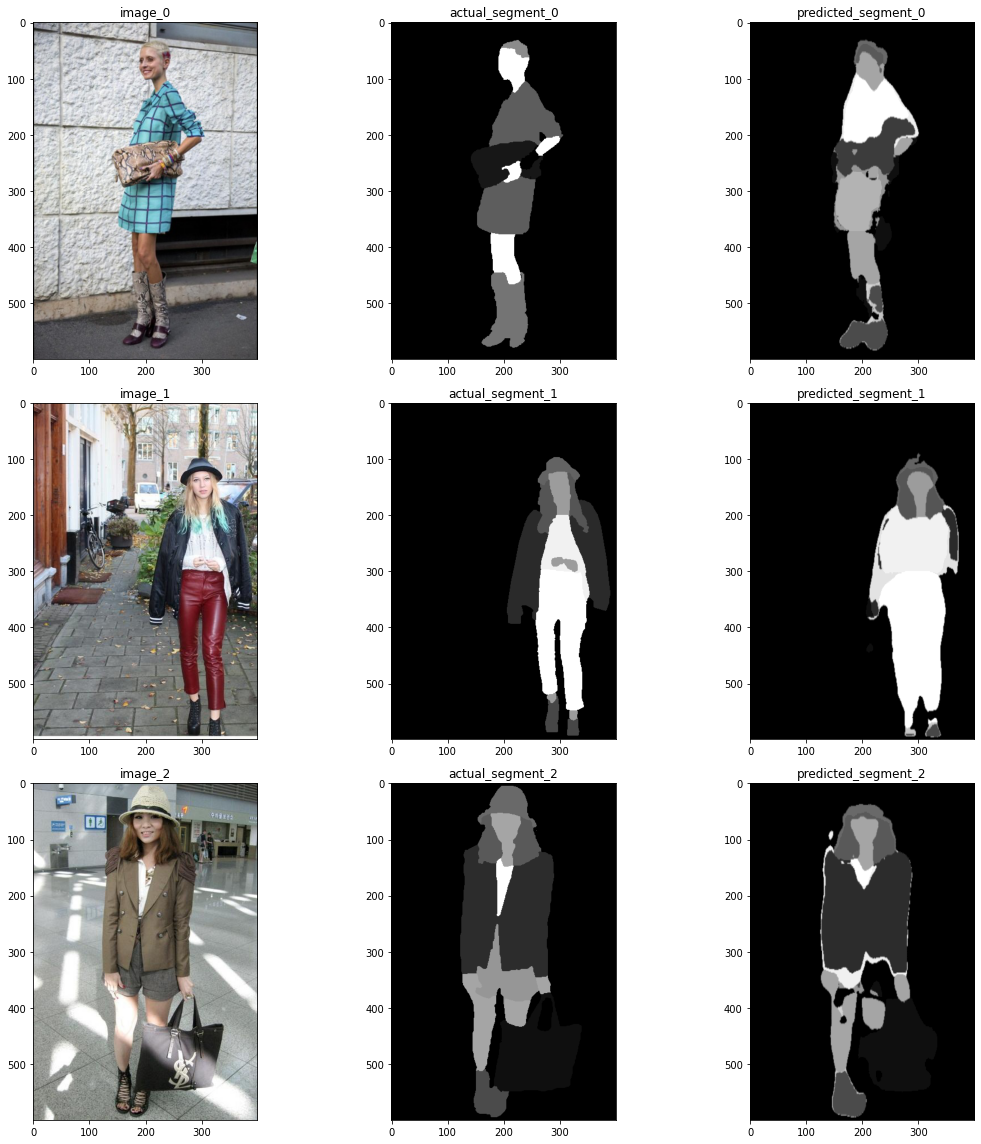

In [29]:
fig,ax=plt.subplots(3,3,figsize=(16,16))
for i in range(3):
  ax[i,0].imshow(cv2.resize(imgs_array[i,:,:],(400,600)))
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(cv2.resize(labels_array[i,:,:],(400,600)),cmap='gray')
  ax[i,1].set_title('actual_segment_{}'.format(i))
  ax[i,2].imshow(cv2.resize(preds_array[i,:,:].astype(np.uint8),(400,600)),cmap='gray')
  ax[i,2].set_title('predicted_segment_{}'.format(i))
fig.tight_layout()
plt.show()